# Day 19 — Feature Selection & Dimensionality Reduction

We use the **Breast Cancer** dataset (from `sklearn.datasets`) to demonstrate:
- Filter methods (correlation)
- Wrapper methods (RFE)
- Embedded methods (L1 / tree importances)
- Dimensionality reduction (PCA & t-SNE)
- Pipeline integration and cross-validation





## 1) Setup & Data Loading

Imports and load the `breast_cancer` dataset into a pandas DataFrame, then perform quick EDA.

In [1]:

# Basic imports and dataset loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame=True)
X = data.frame.drop(columns=['target'])
y = data.frame['target']

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())

# Show head of dataframe
X.head()


Features shape: (569, 30)
Target distribution:
 target
1    357
0    212
Name: count, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 2) Baseline Models (Logistic Regression & Random Forest)

Train baseline models on raw features and evaluate using train/test split and cross-validation.

In [2]:

# Train/test split and baseline training
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Logistic Regression baseline
lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1]

# Random Forest baseline
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print('Logistic Regression - Test Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Logistic Regression - ROC AUC:', roc_auc_score(y_test, y_proba_lr))
print('\nRandom Forest - Test Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Random Forest - ROC AUC:', roc_auc_score(y_test, y_proba_rf))

print('\nLogistic Regression classification report:\n', classification_report(y_test, y_pred_lr))
print('\nRandom Forest classification report:\n', classification_report(y_test, y_pred_rf))


Logistic Regression - Test Accuracy: 0.956140350877193
Logistic Regression - ROC AUC: 0.9957010582010581

Random Forest - Test Accuracy: 0.956140350877193
Random Forest - ROC AUC: 0.9930555555555556

Logistic Regression classification report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


Random Forest classification report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## 3) Filter Method — Correlation-Based Feature Removal

Remove features with very high correlation (multicollinearity) and retrain models.

In [3]:

# Correlation matrix and feature removal
corr = X.corr().abs()

# Upper triangle corr matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
len(to_drop), to_drop[:10]


(7,
 ['mean perimeter',
  'mean area',
  'perimeter error',
  'area error',
  'worst radius',
  'worst perimeter',
  'worst area'])

In [4]:

# Drop highly correlated features and retrain
X_reduced_corr = X.drop(columns=to_drop)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced_corr, y, test_size=0.2, stratify=y, random_state=42)

lr_r = LogisticRegression(max_iter=1000, solver='liblinear').fit(X_train_r, y_train_r)
rf_r = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train_r, y_train_r)

from sklearn.metrics import accuracy_score, roc_auc_score
print('Logistic Regression after corr-drop - Accuracy:', accuracy_score(y_test_r, lr_r.predict(X_test_r)))
print('Logistic Regression after corr-drop - ROC AUC:', roc_auc_score(y_test_r, lr_r.predict_proba(X_test_r)[:,1]))
print('\nRandom Forest after corr-drop - Accuracy:', accuracy_score(y_test_r, rf_r.predict(X_test_r)))
print('Random Forest after corr-drop - ROC AUC:', roc_auc_score(y_test_r, rf_r.predict_proba(X_test_r)[:,1]))


Logistic Regression after corr-drop - Accuracy: 0.956140350877193
Logistic Regression after corr-drop - ROC AUC: 0.9910714285714286

Random Forest after corr-drop - Accuracy: 0.9649122807017544
Random Forest after corr-drop - ROC AUC: 0.9917328042328042


## 4) Wrapper Method — Recursive Feature Elimination (RFE)

Use RFE with Logistic Regression to find top features.

In [5]:

from sklearn.feature_selection import RFE

# RFE with Logistic Regression to select top 10 features
lr_full = LogisticRegression(max_iter=2000, solver='liblinear')
rfe = RFE(estimator=lr_full, n_features_to_select=10, step=1)
rfe.fit(X_train, y_train)

selected_features_rfe = X.columns[rfe.support_].tolist()
selected_features_rfe


['mean radius',
 'mean concavity',
 'mean concave points',
 'perimeter error',
 'area error',
 'worst radius',
 'worst perimeter',
 'worst compactness',
 'worst concavity',
 'worst concave points']

In [6]:

# Train models on RFE-selected features
X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

lr_rfe = LogisticRegression(max_iter=1000, solver='liblinear').fit(X_train_rfe, y_train)
rf_rfe = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train_rfe, y_train)

print('Logistic Regression (RFE) - Test Accuracy:', accuracy_score(y_test, lr_rfe.predict(X_test_rfe)))
print('Logistic Regression (RFE) - ROC AUC:', roc_auc_score(y_test, lr_rfe.predict_proba(X_test_rfe)[:,1]))
print('\nRandom Forest (RFE) - Test Accuracy:', accuracy_score(y_test, rf_rfe.predict(X_test_rfe)))
print('Random Forest (RFE) - ROC AUC:', roc_auc_score(y_test, rf_rfe.predict_proba(X_test_rfe)[:,1]))


Logistic Regression (RFE) - Test Accuracy: 0.956140350877193
Logistic Regression (RFE) - ROC AUC: 0.9854497354497355

Random Forest (RFE) - Test Accuracy: 0.9473684210526315
Random Forest (RFE) - ROC AUC: 0.990079365079365


## 5) Embedded Methods — L1 (Lasso) and Tree Importances

Use L1-penalized Logistic Regression and RandomForest feature importances.

In [7]:

from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel

# L1 Logistic (use liblinear solver)
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000)
lr_l1.fit(X_train, y_train)

# Use SelectFromModel to choose non-zero coefficients
sfm = SelectFromModel(lr_l1, prefit=True)
selected_l1 = X.columns[sfm.get_support()].tolist()
selected_l1


['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'texture error',
 'area error',
 'worst texture',
 'worst perimeter',
 'worst area',
 'worst concavity']

In [8]:

# Tree-based importances
rf_full = RandomForestClassifier(n_estimators=500, random_state=42)
rf_full.fit(X_train, y_train)
importances = pd.Series(rf_full.feature_importances_, index=X.columns).sort_values(ascending=False)
top_tree = importances.head(10)
top_tree


,0
worst area,0.130008
worst perimeter,0.127948
worst concave points,0.127183
worst radius,0.092807
mean concave points,0.089029
mean radius,0.054538
mean concavity,0.050924
mean perimeter,0.049703
mean area,0.042165
area error,0.037021


In [9]:

# Train on L1-selected features and tree-top features
X_train_l1 = X_train[selected_l1]
X_test_l1 = X_test[selected_l1]

if len(selected_l1) > 0:
    lr_l1_model = LogisticRegression(max_iter=2000, solver='liblinear').fit(X_train_l1, y_train)
    print('Logistic Regression (L1) - Test Accuracy:', accuracy_score(y_test, lr_l1_model.predict(X_test_l1)))
    print('Logistic Regression (L1) - ROC AUC:', roc_auc_score(y_test, lr_l1_model.predict_proba(X_test_l1)[:,1]))
else:
    print('No features selected by L1.')

# RandomForest on top tree features
top_tree_features = top_tree.index.tolist()
X_train_tree = X_train[top_tree_features]
X_test_tree = X_test[top_tree_features]
rf_tree = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train_tree, y_train)
print('\nRandom Forest (Top tree features) - Test Accuracy:', accuracy_score(y_test, rf_tree.predict(X_test_tree)))
print('Random Forest (Top tree features) - ROC AUC:', roc_auc_score(y_test, rf_tree.predict_proba(X_test_tree)[:,1]))


Logistic Regression (L1) - Test Accuracy: 0.9649122807017544
Logistic Regression (L1) - ROC AUC: 0.9957010582010581

Random Forest (Top tree features) - Test Accuracy: 0.956140350877193
Random Forest (Top tree features) - ROC AUC: 0.9854497354497355


## 6) Dimensionality Reduction — PCA & t-SNE

Visualize PCA explained variance and 2D projections with PCA and t-SNE.

Number of components to explain 95% variance: 1


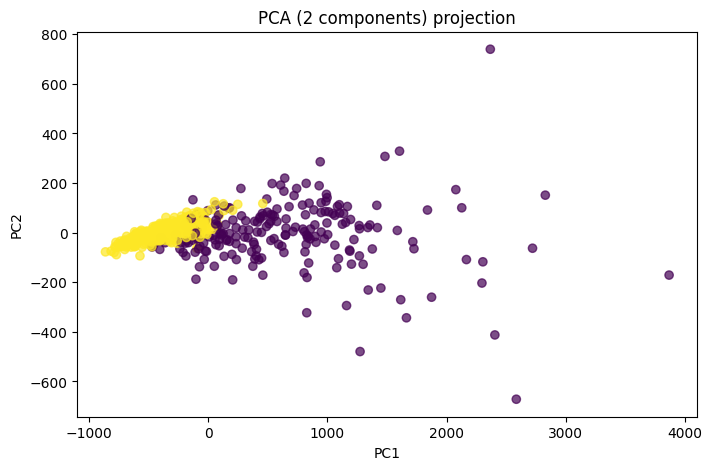

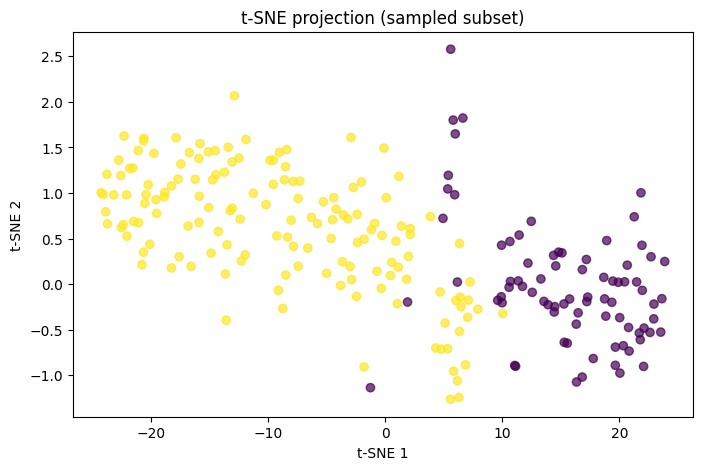

In [10]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA explained variance
pca = PCA(n_components=0.95, random_state=42)  # keep 95% variance
pca.fit(X)
print('Number of components to explain 95% variance:', pca.n_components_)

# PCA to 2 components for visualization
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X)

plt.figure(figsize=(8,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, cmap='viridis', alpha=0.7)
plt.title('PCA (2 components) projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# t-SNE (note: this can be slower; reduce to 200 samples for speed in notebooks)
sample_frac = 0.4
X_sample = X.sample(frac=sample_frac, random_state=42)
y_sample = y.loc[X_sample.index]

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_sample)

plt.figure(figsize=(8,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_sample, cmap='viridis', alpha=0.7)
plt.title('t-SNE projection (sampled subset)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


## 7) Pipeline Integration & Cross-Validation

Create pipelines that include feature selection and a classifier, then evaluate with Stratified CV.

In [11]:

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate

# Pipeline: SelectFromModel (using RF importances) + LogisticRegression
selector = SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42), threshold='median')
pipe = Pipeline([('selector', selector),
                 ('clf', LogisticRegression(max_iter=2000, solver='liblinear'))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)
pd.DataFrame(cv_results).T


,0,1,2,3,4
fit_time,0.948166,0.878970,0.736390,0.699135,0.733655
score_time,0.100420,0.148388,0.125924,0.080399,0.096256
test_accuracy,0.956140,0.912281,0.938596,0.964912,0.973451
test_precision,0.985294,0.896104,0.933333,0.985714,0.959459
test_recall,0.943662,0.971831,0.972222,0.958333,1.000000
test_f1,0.964029,0.932432,0.952381,0.971831,0.979310
test_roc_auc,0.994759,0.986243,0.984458,0.997354,0.998659
